# Fix demuxing
of temperature replica exchange trajectories for oligomers

In [1]:
import time, os, pandas
import numpy as np
import MDAnalysis as mda
from scipy.spatial import distance
import matplotlib.pyplot as plt

## Basic function: `demuxing`

`demuxing` will give `replica_index` (columns then `replica_temp = np.argsort(replica_index, axis=1)`

https://gromacs.bioexcel.eu/t/difference-between-replica-index-xvg-and-replica-temp-xvg/5540

- `replica_index` and `replica_temp` are mutually inverse: `replica_temp` shows the diffusion of each replica in temperature space, i.e. each replica (column) is at what temperature; `replica_index` shows the opposite, i.e. each temperature (column) is at which replica

In [2]:
def main_demuxing(x, x_new, threshold = 1e-3, n_replicas = 24, if_assert = True):
    """ this is the inner function of demuxing (NOT imported there) """

    # if (type(my_fun) is float) or (type(my_fun) is int):
    # my_fun = lambda x1, x2 : len(np.where(np.abs(x1 - x2) < threshold)[0])

    def my_fun(x1, x2):
        diff = np.abs(x1 - x2)
        arg = 2*np.pi*(diff[::3] + diff[1::3] + np.sqrt(2)*diff[2::3])
        # cos_dist = 1 - np.cos(arg)
        cos_dist = 1 - np.cos(np.sum(arg))
        return cos_dist
    
    diff = distance.cdist(x, x_new, my_fun)
    """ diff[i, j] is the distance between x[i] and x_new[j] """

    ind = np.argmax(diff, axis=0)
    """ ind[i] is the index of x_new which is the closest to x[i] """

    # you should add a check on unique assignment!
    assert len(np.unique(ind)) == n_replicas
    
    # if len(np.unique(ind)) != n_replicas:
    #     print('error')
    
    return diff, ind

In [2]:
def get_trajectory(paths_traj, n_replicas = 24, start_frame = 0, sup_trajs = None, sup_frames = -1):

    trajs = []

    if sup_trajs is None: sup_trajs = len(paths_traj)

    for n_subtraj in range(sup_trajs):
        
        xtc_read = []  # xtc_read[NR][n_frame][:]
        for n_rep in range(n_replicas):
            xtc_read.append(mda.coordinates.XTC.XTCReader(paths_traj[n_subtraj] % n_rep))
        
        n_frame0 = start_frame
        
        if n_subtraj == 0:
            x = []
            for n_rep in range(n_replicas):
                x.append(xtc_read[n_rep][start_frame][:].flatten())
            
            trajs.append(np.array(x))
            n_frame0 = start_frame + 1  # if already initialised, start from next frame
        
        if sup_frames == -1: sup_frames = len(xtc_read[0])
        
        for n_frame in range(n_frame0, sup_frames):
            x_new = []
            for n_rep in range(n_replicas):
                x_new.append(xtc_read[n_rep][n_frame][:].flatten())

            trajs.append(np.array(x_new))

            if (n_frame % 10) == 0:
                print('n frames: ', n_frame)

    return trajs

In [4]:
from demuxing_fun import demuxing

## Select trajectories and do demuxing on them

In [5]:
sequence = 'GACC'
n_replicas = 24

curr_dir = '/net/sbp/srnas2/tfrahlki/Simulations/%s_TREMD/Production/%s' % (sequence, sequence)

# n_max_subtraj = 100  # 310 for UCAAUC, 100 for UCUCGU (?)

# start_frame = 0

In [6]:
paths_traj = [s for s in os.listdir(curr_dir) if s.startswith('traj_comp0')]  #  and s.endswith('0002.xtc'))]
paths_traj = [s for s in paths_traj if not (s.endswith('full_proc.xtc') or s.endswith('full.xtc'))]

paths_traj.sort()

# first element is traj_comp0.xtc
paths_traj.insert(0, paths_traj[-1])
paths_traj = paths_traj[:-1]

# substitute replica number with %s
for i in range(len(paths_traj)):
    index = 9
    replacement = '%s'

    text_list = list(paths_traj[i])
    text_list[index] = replacement

    paths_traj[i] = ''.join(text_list)

paths_traj = [(curr_dir + '/' + s) for s in paths_traj]



In [5]:
paths_traj

['/net/sbp/srnas2/tfrahlki/Simulations/GACC_TREMD/Production/GACC/traj_comp%s.xtc',
 '/net/sbp/srnas2/tfrahlki/Simulations/GACC_TREMD/Production/GACC/traj_comp%s.part0002.xtc',
 '/net/sbp/srnas2/tfrahlki/Simulations/GACC_TREMD/Production/GACC/traj_comp%s.part0003.xtc',
 '/net/sbp/srnas2/tfrahlki/Simulations/GACC_TREMD/Production/GACC/traj_comp%s.part0004.xtc',
 '/net/sbp/srnas2/tfrahlki/Simulations/GACC_TREMD/Production/GACC/traj_comp%s.part0005.xtc',
 '/net/sbp/srnas2/tfrahlki/Simulations/GACC_TREMD/Production/GACC/traj_comp%s.part0006.xtc',
 '/net/sbp/srnas2/tfrahlki/Simulations/GACC_TREMD/Production/GACC/traj_comp%s.part0007.xtc',
 '/net/sbp/srnas2/tfrahlki/Simulations/GACC_TREMD/Production/GACC/traj_comp%s.part0008.xtc',
 '/net/sbp/srnas2/tfrahlki/Simulations/GACC_TREMD/Production/GACC/traj_comp%s.part0009.xtc',
 '/net/sbp/srnas2/tfrahlki/Simulations/GACC_TREMD/Production/GACC/traj_comp%s.part0010.xtc',
 '/net/sbp/srnas2/tfrahlki/Simulations/GACC_TREMD/Production/GACC/traj_comp%s.p

In [6]:
ts = mda.coordinates.XTC.XTCReader(paths_traj[0] % 0).ts.dimensions

ts

/u/i/igilardo/.local/lib/python3.6/site-packages/MDAnalysis/coordinates/XDR.py:232: UserWarning: Couldn't save offsets because: [Errno 13] Permission denied: '/net/sbp/srnas2/tfrahlki/Simulations/GACC_TREMD/Production/GACC/.traj_comp0.xtc_offsets.npz'
  warnings.warn("Couldn't save offsets because: {}".format(e))


array([51.0528  , 51.0528  , 51.052814, 60.000008, 60.000008, 90.      ],
      dtype=float32)

In [7]:
paths_traj

['/net/sbp/srnas2/tfrahlki/Simulations/GACC_TREMD/Production/GACC/traj_comp%s.xtc',
 '/net/sbp/srnas2/tfrahlki/Simulations/GACC_TREMD/Production/GACC/traj_comp%s.part0002.xtc',
 '/net/sbp/srnas2/tfrahlki/Simulations/GACC_TREMD/Production/GACC/traj_comp%s.part0003.xtc',
 '/net/sbp/srnas2/tfrahlki/Simulations/GACC_TREMD/Production/GACC/traj_comp%s.part0004.xtc',
 '/net/sbp/srnas2/tfrahlki/Simulations/GACC_TREMD/Production/GACC/traj_comp%s.part0005.xtc',
 '/net/sbp/srnas2/tfrahlki/Simulations/GACC_TREMD/Production/GACC/traj_comp%s.part0006.xtc',
 '/net/sbp/srnas2/tfrahlki/Simulations/GACC_TREMD/Production/GACC/traj_comp%s.part0007.xtc',
 '/net/sbp/srnas2/tfrahlki/Simulations/GACC_TREMD/Production/GACC/traj_comp%s.part0008.xtc',
 '/net/sbp/srnas2/tfrahlki/Simulations/GACC_TREMD/Production/GACC/traj_comp%s.part0009.xtc',
 '/net/sbp/srnas2/tfrahlki/Simulations/GACC_TREMD/Production/GACC/traj_comp%s.part0010.xtc',
 '/net/sbp/srnas2/tfrahlki/Simulations/GACC_TREMD/Production/GACC/traj_comp%s.p

In [3]:
!du -hs /net/sbp/srnas2/tfrahlki/Simulations/CCCC_TREMD/Production/CCCC

1,8T	/net/sbp/srnas2/tfrahlki/Simulations/CCCC_TREMD/Production/CCCC


In [6]:
path_print = '../../demuxing'

my_rep_index = demuxing(1e-3, n_replicas, paths_traj, True, path_print, n_print=10)


subtrajectory n.  0


/u/i/igilardo/.local/lib/python3.6/site-packages/MDAnalysis/coordinates/XDR.py:232: UserWarning: Couldn't save offsets because: [Errno 13] Permission denied: '/net/sbp/srnas2/tfrahlki/Simulations/CCCC_TREMD/Production/CCCC/.traj_comp0.xtc_offsets.npz'
  warnings.warn("Couldn't save offsets because: {}".format(e))
/u/i/igilardo/.local/lib/python3.6/site-packages/MDAnalysis/coordinates/XDR.py:232: UserWarning: Couldn't save offsets because: [Errno 13] Permission denied: '/net/sbp/srnas2/tfrahlki/Simulations/CCCC_TREMD/Production/CCCC/.traj_comp1.xtc_offsets.npz'
  warnings.warn("Couldn't save offsets because: {}".format(e))
/u/i/igilardo/.local/lib/python3.6/site-packages/MDAnalysis/coordinates/XDR.py:232: UserWarning: Couldn't save offsets because: [Errno 13] Permission denied: '/net/sbp/srnas2/tfrahlki/Simulations/CCCC_TREMD/Production/CCCC/.traj_comp2.xtc_offsets.npz'
  warnings.warn("Couldn't save offsets because: {}".format(e))
/u/i/igilardo/.local/lib/python3.6/site-packages/MDAnal

n frames:  10
n frames:  20
n frames:  30
n frames:  40
n frames:  50
n frames:  60
n frames:  70
n frames:  80
n frames:  90
0


In [70]:
my_rep_index

array([[ 0,  1,  2, ..., 21, 22, 23],
       [ 0,  1,  3, ..., 20, 22, 23],
       [ 1,  0,  2, ..., 20, 22, 23],
       ...,
       [ 4, 21, 16, ...,  5, 19,  1],
       [ 4, 16, 21, ..., 18,  1, 19],
       [16,  4, 21, ..., 18,  1, 19]])

## Compare with *replica_index* by Salvo
done by looking at `log` files with Plumed

load replica_index by Salvo as `rep_index_pl`
- skip first column (because frame index) but do not skip first frame/row (even if this has been done for `my_rep_index`)

In [3]:
sys_name = 'AAAA'
path = '../../../../../../net/sbp/srnas2/sdimarco/%s/demuxing/' % sys_name
my_list = os.listdir(path)

# list(filter(lambda x: x.startswith('replica'), my_list))
rep_index_pl = np.loadtxt(path + 'replica_index_cat_stride.xvg')[:, 1:]

print(rep_index_pl.shape)

(1017000, 24)


load replica_index done by myself as `my_rep_index`

In [4]:
my_rep_index = np.loadtxt('../../demuxing_results_%s/2025_03_11_20_52_25_replica_index' % sys_name, delimiter=',')

print(my_rep_index.shape)

(1017001, 24)


compare the two

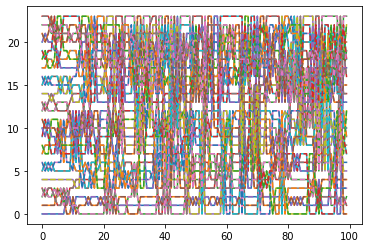

In [5]:
plt.plot(rep_index_pl[:100])
plt.plot(my_rep_index[:100], '--')
plt.show()

[ 2. 12. 12. 10. 10. 10. 10. 19. 10. 12. 10. 10. 16. 13. 13. 13. 19. 16.
 16.  6. 16. 19. 19. 19. 19. 10.  2.  6.  6.  6.  6.  6.  6.  2.  2.  6.
  6.  6.  2.  6.  6.  6.  6.  2.  2. 19.  6.  6.  6. 16. 16. 19.  1.  1.
  6.  1. 16. 16. 23. 23. 16. 15.  6. 12. 15. 15. 15. 15. 19. 19.  6.  6.
 23. 23. 23. 23. 15.  1. 15. 16. 19. 15. 16. 16. 16. 16. 12. 15. 12. 12.
 12. 23. 19. 15. 15. 15.  2. 15. 15. 15. 15. 15. 16.  2. 20. 20. 15. 15.
  2.  2. 15.  2.  6.  2.  2.  2.  2.  2.  2. 20.  2.  2.  5.  5.  2.  2.
  2.  5.  5.  2. 12. 12.  2.  1.  1. 20.  1.  1.  1. 23. 16. 16.  1.  1.
  2.  1.  1.  1.  1.  1. 16. 16.  1.  2.  1.  2.  2.  2. 20.  1.  1. 20.
 20. 20. 20. 16. 16. 12.  1. 12. 12. 12. 19. 19.  4. 16.  4. 19. 16. 19.
 19. 19. 19. 12. 12. 12. 12. 16. 16.  4.  5.  5.  5.  5.  5.  7.  1.  7.
  7.  2.  5.  7.  5.  7. 12.  7. 12.  5.  5.  7.  7.  2.  6.  2.  6.  2.
  7.  7.  6.  6.  6.  6.  6. 16.  6.  6. 19. 19. 16. 23. 16. 19.  7.  7.
 19. 19. 19.  7. 19. 19. 19.  4.  4. 19.  4.  6.  6

Text(0.5, 1.0, 'replica_index at T = 18')

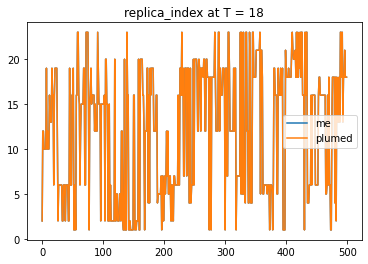

In [6]:
n_temp = 18
lim_sup = 9500
lim_inf = 9000

print(my_rep_index[lim_inf:lim_sup, n_temp])

print(rep_index_pl[lim_inf:lim_sup, n_temp])

plt.plot(my_rep_index[lim_inf:lim_sup, n_temp], '-', label='me')
plt.plot(rep_index_pl[lim_inf:lim_sup, n_temp], '-', label='plumed')
plt.legend()
plt.title('replica_index at T = %i' % n_temp)

# plt.savefig('compare_replica_index.pdf', format='pdf', bbox_inches='tight')

transform replica_index to replica_temp

In [7]:
my_rep_temp = np.argsort(my_rep_index, axis=1)
rep_temp_pl = np.argsort(rep_index_pl, axis=1)

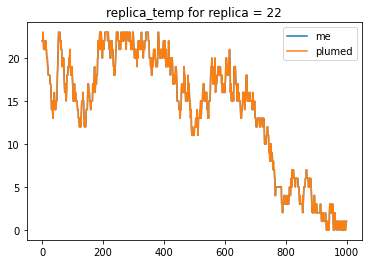

In [7]:
n_replica = 22
limsup = 1000

plt.title('replica_temp for replica = %i' % n_replica)
plt.plot(my_rep_temp[:limsup, n_replica], '-', label='me')
plt.plot(rep_temp_pl[:limsup, n_replica], '-', label='plumed')
plt.legend()
plt.show()

In [8]:
check = rep_index_pl - my_rep_index[:-1]

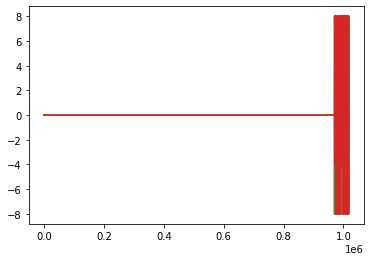

In [9]:
for i in range(check.shape[1]):
    plt.plot(check[:, i])

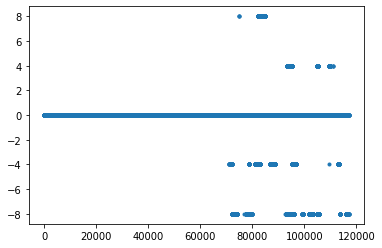

In [10]:
plt.plot(check[int(9e5):, 0], '.')
# plt.plot(check[int(8e5):, 1])

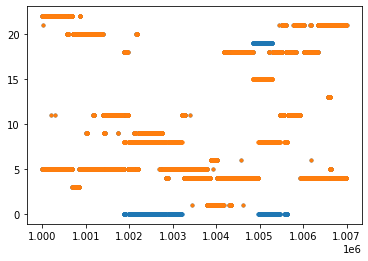

In [11]:
inf = int(10e5)
sup = int(10.07e5)  # len(rep_index_pl)
n_temp = 1

x = np.arange(inf, sup)
plt.plot(x, rep_index_pl[inf:sup, n_temp], '.')
plt.plot(x, my_rep_index[inf:sup, n_temp], '.')


In [10]:
check2 = rep_temp_pl - my_rep_temp[:-1]

compare the two replica_temp (remind: they are the table whose columns correspond to the replica_index and the values in their cells to the temperature): only some of them (even n.) have a mismatch between `log` files and the outcome of my demuxing algorithm!

if instead we compare the two replica_index, for all of them there is a mismatch

replica n. 1 is in complete agreement
replica n. 2 is in complete agreement
replica n. 3 is in complete agreement
replica n. 4 is in complete agreement
replica n. 5 is in complete agreement
replica n. 6 is in complete agreement
replica n. 7 is in complete agreement
replica n. 9 is in complete agreement
replica n. 10 is in complete agreement
replica n. 11 is in complete agreement
replica n. 12 is in complete agreement
replica n. 13 is in complete agreement
replica n. 14 is in complete agreement
replica n. 16 is in complete agreement
replica n. 17 is in complete agreement
replica n. 18 is in complete agreement
replica n. 20 is in complete agreement
replica n. 21 is in complete agreement
replica n. 22 is in complete agreement
replica n. 23 is in complete agreement


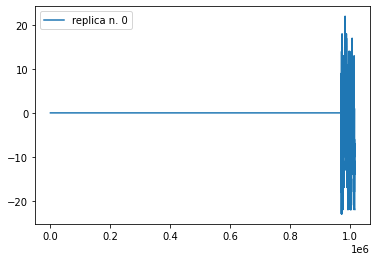

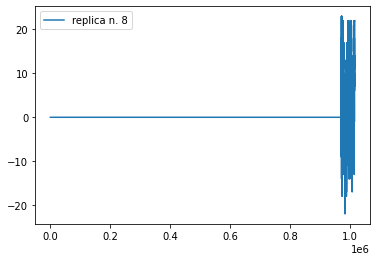

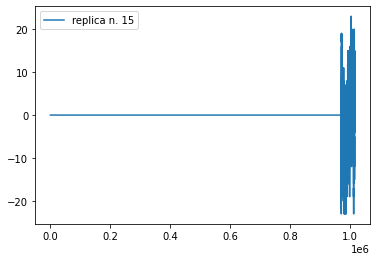

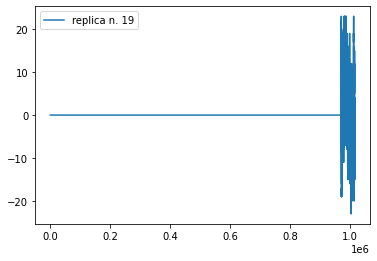

In [11]:
lim_inf = 0  # int(8.7e5)
x = np.arange(lim_inf, len(check2))

for i in range(check2.shape[1]):
    if np.count_nonzero(check2[:, i]) != 0:
        plt.figure()
        plt.plot(x, check2[lim_inf:, i], label='replica n. %i' % i)
        plt.legend()
    else:
        print('replica n. %i is in complete agreement' % i)

/u/i/igilardo/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


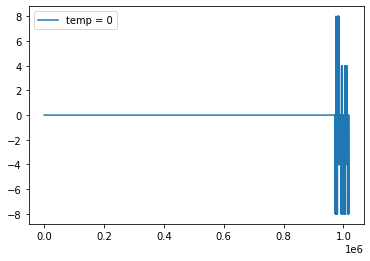

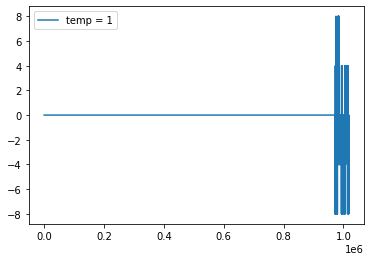

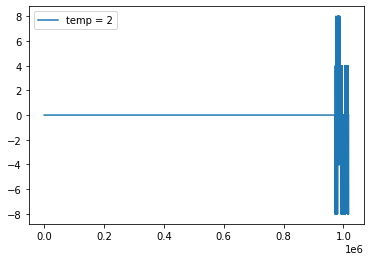

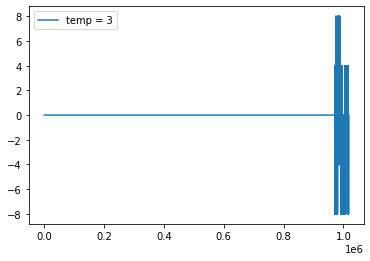

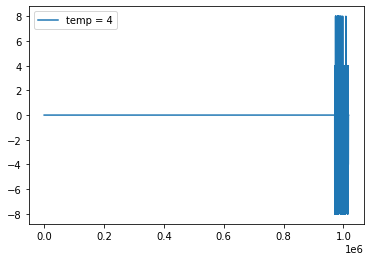

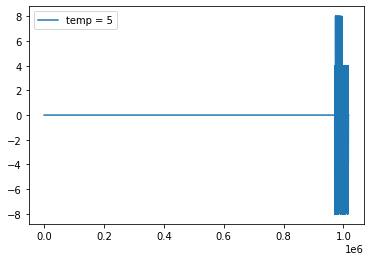

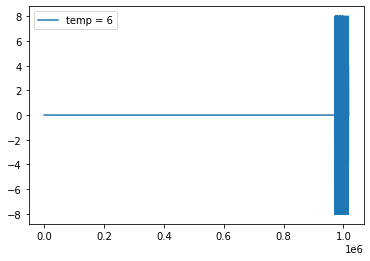

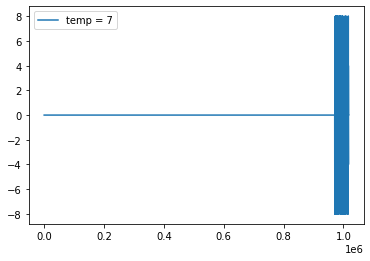

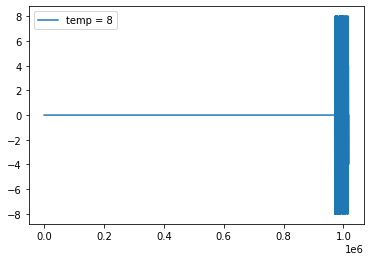

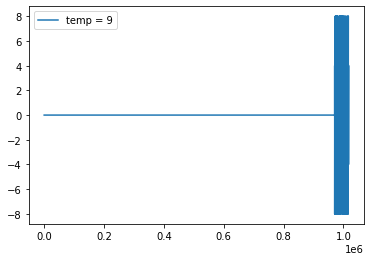

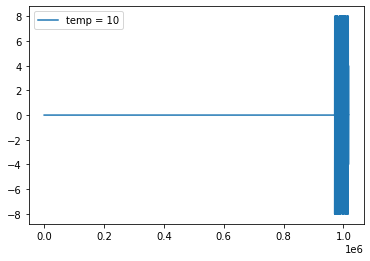

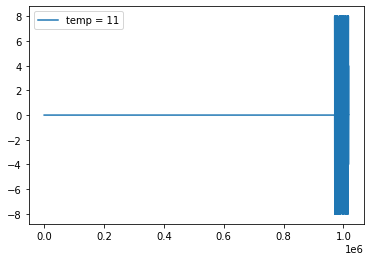

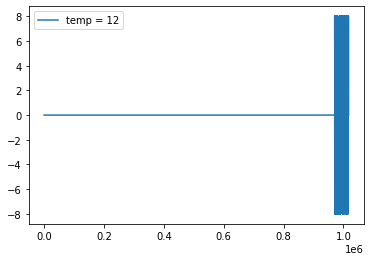

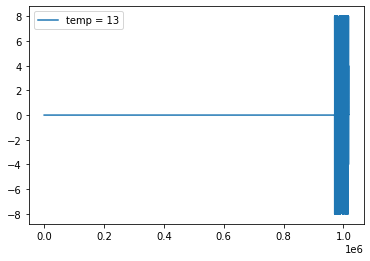

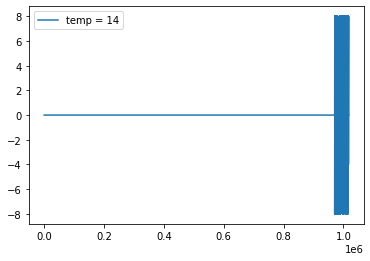

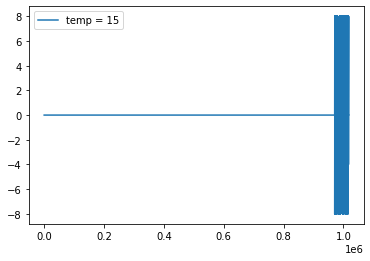

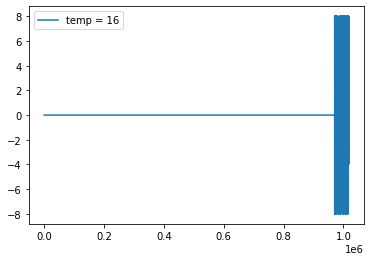

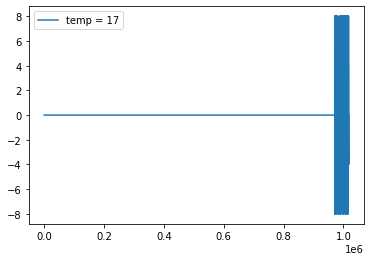

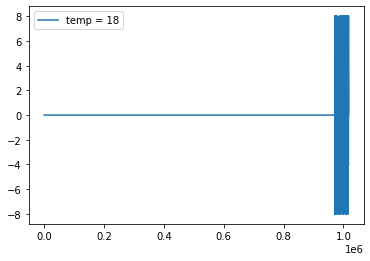

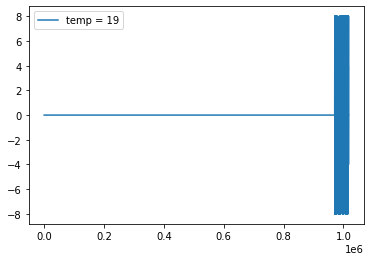

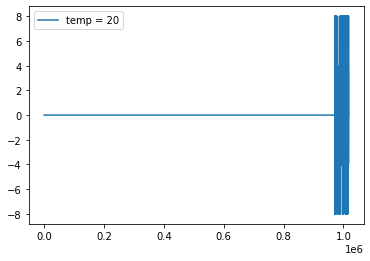

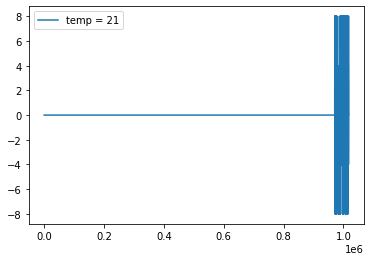

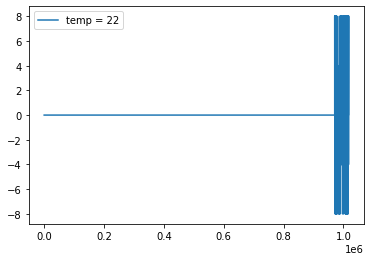

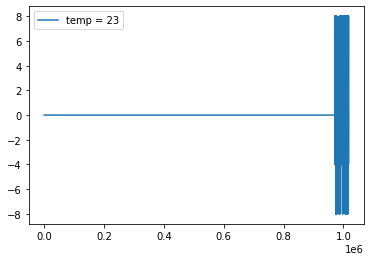

In [11]:
lim_inf = 0  # int(8.7e5)
x = np.arange(lim_inf, len(check))

for i in range(check.shape[1]):
    if np.count_nonzero(check[:, i]) != 0:
        plt.figure()
        plt.plot(x, check[lim_inf:, i], label='temp = %i' % i)
        plt.legend()
    else:
        print('temperature n. %i is in complete agreement' % i)

why there is this mismatch?

let's look at the trajectory to conclude which of the two is correct

In [12]:
wh = np.argwhere(check != 0)[:4]

wh

array([[970684,     10],
       [970684,     11],
       [970684,     14],
       [970684,     16]])

In [14]:
wh = np.argwhere(check2 != 0)[:4]

wh

array([[970684,      0],
       [970684,      8],
       [970684,     15],
       [970684,     19]])

so we have to search for frame n. 970.684

### let's look at the trajectory

the full trajectory is decomposed in subtrajectories, make a sorted list of them

In [13]:
dir_simul = '/net/sbp/srnas2/tfrahlki/Simulations/%s_TREMD/Production/%s' % (sys_name, sys_name)

paths_traj = [s for s in os.listdir(dir_simul) if s.startswith('traj_comp0')]  #  and s.endswith('0002.xtc'))]
paths_traj = [s for s in paths_traj if not (s.endswith('full_proc.xtc') or s.endswith('full.xtc'))]

paths_traj.sort()

# first element is traj_comp0.xtc
paths_traj.insert(0, paths_traj[-1])
paths_traj = paths_traj[:-1]

# substitute replica number with %s
for i in range(len(paths_traj)):
    index = 9
    replacement = '%s'

    text_list = list(paths_traj[i])
    text_list[index] = replacement

    paths_traj[i] = ''.join(text_list)

paths_traj = [(dir_simul + '/' + s) for s in paths_traj]

paths_traj

['/net/sbp/srnas2/tfrahlki/Simulations/AAAA_TREMD/Production/AAAA/traj_comp%s.xtc',
 '/net/sbp/srnas2/tfrahlki/Simulations/AAAA_TREMD/Production/AAAA/traj_comp%s.part0002.xtc',
 '/net/sbp/srnas2/tfrahlki/Simulations/AAAA_TREMD/Production/AAAA/traj_comp%s.part0003.xtc',
 '/net/sbp/srnas2/tfrahlki/Simulations/AAAA_TREMD/Production/AAAA/traj_comp%s.part0004.xtc',
 '/net/sbp/srnas2/tfrahlki/Simulations/AAAA_TREMD/Production/AAAA/traj_comp%s.part0005.xtc',
 '/net/sbp/srnas2/tfrahlki/Simulations/AAAA_TREMD/Production/AAAA/traj_comp%s.part0006.xtc',
 '/net/sbp/srnas2/tfrahlki/Simulations/AAAA_TREMD/Production/AAAA/traj_comp%s.part0007.xtc',
 '/net/sbp/srnas2/tfrahlki/Simulations/AAAA_TREMD/Production/AAAA/traj_comp%s.part0008.xtc',
 '/net/sbp/srnas2/tfrahlki/Simulations/AAAA_TREMD/Production/AAAA/traj_comp%s.part0009.xtc',
 '/net/sbp/srnas2/tfrahlki/Simulations/AAAA_TREMD/Production/AAAA/traj_comp%s.part0010.xtc',
 '/net/sbp/srnas2/tfrahlki/Simulations/AAAA_TREMD/Production/AAAA/traj_comp%s.p

make a list of the n. of frames in each subtrajectory

In [14]:
n_subtraj = 0
n_temp = 0

list_n_frames = []
for subtraj in paths_traj:
    list_n_frames.append(mda.coordinates.XTC.XTCReader(subtraj % n_temp).n_frames)

/u/i/igilardo/.local/lib/python3.6/site-packages/MDAnalysis/coordinates/XDR.py:232: UserWarning: Couldn't save offsets because: [Errno 13] Permission denied: '/net/sbp/srnas2/tfrahlki/Simulations/AAAA_TREMD/Production/AAAA/.traj_comp0.xtc_offsets.npz'
  warnings.warn("Couldn't save offsets because: {}".format(e))
/u/i/igilardo/.local/lib/python3.6/site-packages/MDAnalysis/coordinates/XDR.py:232: UserWarning: Couldn't save offsets because: [Errno 13] Permission denied: '/net/sbp/srnas2/tfrahlki/Simulations/AAAA_TREMD/Production/AAAA/.traj_comp0.part0002.xtc_offsets.npz'
  warnings.warn("Couldn't save offsets because: {}".format(e))
/u/i/igilardo/.local/lib/python3.6/site-packages/MDAnalysis/coordinates/XDR.py:232: UserWarning: Couldn't save offsets because: [Errno 13] Permission denied: '/net/sbp/srnas2/tfrahlki/Simulations/AAAA_TREMD/Production/AAAA/.traj_comp0.part0003.xtc_offsets.npz'
  warnings.warn("Couldn't save offsets because: {}".format(e))
/u/i/igilardo/.local/lib/python3.6/si

In [15]:
cum_sum_n_frames = np.cumsum(list_n_frames)

cum_sum_n_frames -= np.arange(len(cum_sum_n_frames)) + 1

cum_sum_n_frames

array([  10000,   20000,   30000,   40000,   50000,   60000,   70000,
         80000,   85000,   90000,   95000,  100000,  105000,  110000,
        115000,  120000,  125000,  130000,  135000,  140000,  145000,
        150000,  155000,  160000,  165000,  170000,  175000,  180000,
        185000,  190000,  195000,  200000,  205000,  210000,  215000,
        220000,  225000,  230000,  235000,  240000,  245000,  250000,
        255000,  260000,  265000,  270000,  275000,  280000,  285000,
        290000,  295000,  300000,  305000,  310000,  315000,  320000,
        325000,  330000,  335000,  340000,  345000,  350000,  355000,
        360000,  365000,  370000,  375000,  380000,  385000,  390000,
        395000,  400000,  405000,  410000,  415000,  420000,  425000,
        430000,  435000,  440000,  445000,  450000,  455000,  460000,
        465000,  470000,  475000,  480000,  485000,  490000,  495000,
        500000,  505000,  510000,  515000,  520000,  525000,  530000,
        535000,  540

so the frames I am searching for are in `paths_traj[-6]`

In [16]:
wh[0][0]

970684

In [17]:
n_frame = wh[0][0] - cum_sum_n_frames[-7]

n_frame  # 621

1684

it's the n. 1684 of subtrajectory n. -6

### demuxing on single subtrajectory

to check the consistency

try firstly on the first subtrajectory, where you already have correct results, then you will do demuxing on subtrajectory n. -6 (containing the first mismatch)

In [18]:
from demuxing_fun import demuxing_single_move, reciprocal_lattice, periodical_distance

In [19]:
# do demuxing up to limsup_frame

# n_subtrajectory = 0
# limsup_frame = 300
# last_frame = 0
# starting_frame = 0

# n_subtrajectory = -6
# limsup_frame = 700
# last_frame = 969000
# # remember to skip the first frame in each subtrajectory, so 969304 will correspond to 969000
# starting_frame = 0

n_subtrajectory = -6
limsup_frame = 2000
last_frame = 969000
starting_frame = 0

In [20]:
n_replicas = 24

trajs = get_trajectory([paths_traj[n_subtrajectory]], n_replicas, sup_frames=limsup_frame)

/u/i/igilardo/.local/lib/python3.6/site-packages/MDAnalysis/coordinates/XDR.py:232: UserWarning: Couldn't save offsets because: [Errno 13] Permission denied: '/net/sbp/srnas2/tfrahlki/Simulations/AAAA_TREMD/Production/AAAA/.traj_comp1.part0305.xtc_offsets.npz'
  warnings.warn("Couldn't save offsets because: {}".format(e))
/u/i/igilardo/.local/lib/python3.6/site-packages/MDAnalysis/coordinates/XDR.py:232: UserWarning: Couldn't save offsets because: [Errno 13] Permission denied: '/net/sbp/srnas2/tfrahlki/Simulations/AAAA_TREMD/Production/AAAA/.traj_comp2.part0305.xtc_offsets.npz'
  warnings.warn("Couldn't save offsets because: {}".format(e))
/u/i/igilardo/.local/lib/python3.6/site-packages/MDAnalysis/coordinates/XDR.py:232: UserWarning: Couldn't save offsets because: [Errno 13] Permission denied: '/net/sbp/srnas2/tfrahlki/Simulations/AAAA_TREMD/Production/AAAA/.traj_comp3.part0305.xtc_offsets.npz'
  warnings.warn("Couldn't save offsets because: {}".format(e))
/u/i/igilardo/.local/lib/pyt

n frames:  10
n frames:  20
n frames:  30
n frames:  40
n frames:  50
n frames:  60
n frames:  70
n frames:  80
n frames:  90
n frames:  100
n frames:  110
n frames:  120
n frames:  130
n frames:  140
n frames:  150
n frames:  160
n frames:  170
n frames:  180
n frames:  190
n frames:  200
n frames:  210
n frames:  220
n frames:  230
n frames:  240
n frames:  250
n frames:  260
n frames:  270
n frames:  280
n frames:  290
n frames:  300
n frames:  310
n frames:  320
n frames:  330
n frames:  340
n frames:  350
n frames:  360
n frames:  370
n frames:  380
n frames:  390
n frames:  400
n frames:  410
n frames:  420
n frames:  430
n frames:  440
n frames:  450
n frames:  460
n frames:  470
n frames:  480
n frames:  490
n frames:  500
n frames:  510
n frames:  520
n frames:  530
n frames:  540
n frames:  550
n frames:  560
n frames:  570
n frames:  580
n frames:  590
n frames:  600
n frames:  610
n frames:  620
n frames:  630
n frames:  640
n frames:  650
n frames:  660
n frames:  670
n fr

repeat demuxing on this subtrajectory and compare it with `my_rep_temp` (with the indices starting from the first frame of this subtrajectory) in order to check

In [21]:
dim = mda.coordinates.XTC.XTCReader(paths_traj[0] % 0).ts.dimensions

h = reciprocal_lattice(dim, 'primitive vectors')
h_inv = np.linalg.inv(h)
my_fun = lambda x1, x2 : periodical_distance(x1, x2, h, h_inv)

In [22]:
repl_indices = []

repl_indices.append(np.arange(n_replicas))

x = trajs[starting_frame]

for i, x_new in enumerate(trajs[(starting_frame + 1):limsup_frame]):
    ind = demuxing_single_move(x, x_new, my_fun)
    x = np.array(x_new)
    repl_indices.append(repl_indices[-1][ind])

    if np.mod(i, 100) == 0: print(i)


0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900


rescale the permutations by starting from frame n. `starting_frame` of that subtrajectory

In [23]:
rep_index_pl_rescaled = +rep_index_pl[last_frame:]

for i in range(rep_index_pl_rescaled.shape[1]):
    rep_index_pl_rescaled[np.where(rep_index_pl_rescaled == rep_index_pl_rescaled[starting_frame, i])] = 100 + i

rep_index_pl_rescaled -= 100

In [24]:
my_rep_index_rescaled = +my_rep_index[last_frame:]

for i in range(my_rep_index_rescaled.shape[1]):
    my_rep_index_rescaled[np.where(my_rep_index_rescaled == my_rep_index_rescaled[starting_frame, i])] = 100 + i

my_rep_index_rescaled -= 100

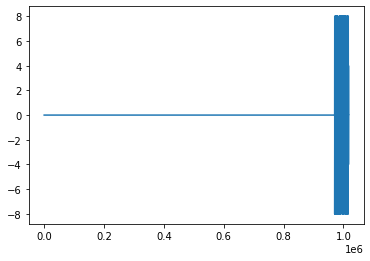

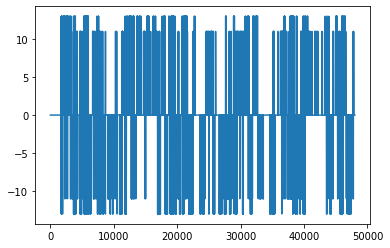

In [25]:
n = 10

plt.plot(rep_index_pl[:, n] - my_rep_index[:-1, n])

plt.figure()
plt.plot(rep_index_pl_rescaled[:, n] - my_rep_index_rescaled[:-1, n])

In [28]:
repl_indices = np.array(repl_indices)

(array([1684, 1688, 1689, 1690, 1691, 1692, 1693, 1694, 1700, 1701, 1703,
       1704, 1705, 1706, 1707, 1708, 1712, 1713, 1714, 1722, 1724, 1726,
       1727, 1728, 1729, 1730, 1733, 1734, 1738, 1739, 1740, 1741, 1742,
       1752, 1753, 1754, 1760, 1761, 1764, 1765, 1766, 1768, 1786, 1787,
       1797, 1798, 1808, 1851, 1912, 1913, 1914, 1915, 1916, 1924, 1925,
       1926, 1927, 1928, 1933, 1934, 1936, 1937, 1939, 1940]),)


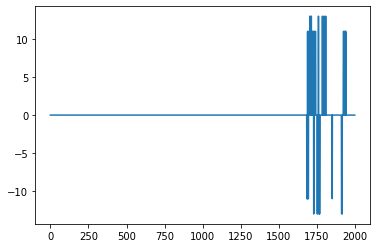

In [40]:
diff = rep_index_pl_rescaled[:2000, n] - repl_indices[:, n]

plt.figure()
plt.plot(diff)

wh = np.where(diff != 0)
print(wh)

In [66]:
print(np.arange(n_replicas), '\n')

for i in [1683, 1684, 1685]:
    print(repl_indices[i])
    print(np.int64(rep_index_pl_rescaled[i]), '\n')

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23] 

[ 4 11  2 21 10  3  1  9 20 23 16  5 14  8  0 18 17 13  7 22  6 15 19 12]
[ 4 11  2 21 10  3  1  9 20 23 16  5 14  8  0 18 17 13  7 22  6 15 19 12] 

[11  4 21 10  2  1 20  3  9 23 16  5  8 14 13 18  0 17  7  6 19 22 15 12]
[11  4 21 10  2  1 20  3  9 23  5 16  8 14  0 18 13 17  7  6 19 22 15 12] 

[ 4 11 10 21  1  2 20  3  9 16 23  5  8 14  0 13 17  7 18  6 22 15 19 12]
[ 4 11 10 21  1  2 20  3  9  5 23 16  8 14 13  0 17  7 18  6 22 15 19 12] 



so I get correctly 1684 as the first frame where there is a mismatch

differences with replica_index from Plumed when passing from frame n. 1683 to n. 1684:
- replicas at temp. 10 and 11 do not swap
- replica at temp. 14 goes to temp. 16 rather than not doing swap
- replica at temp. 17 goes to temp. 14 rather than 16


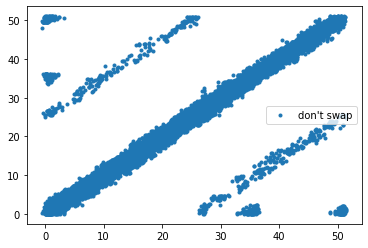

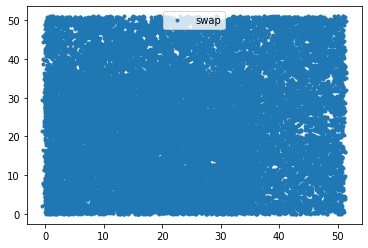

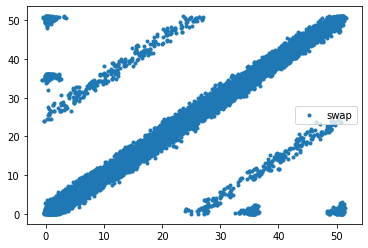

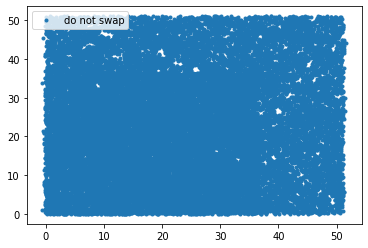

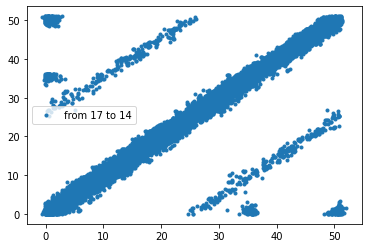

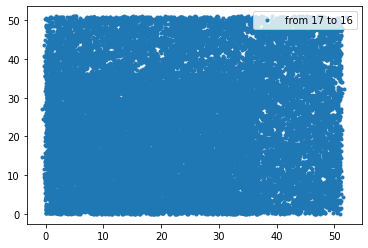

In [72]:
plt.plot(trajs[1683][10], trajs[1684][10], '.', label="don't swap")
plt.legend()

plt.figure()
plt.plot(trajs[1683][10], trajs[1684][11], '.', label='swap')
plt.legend()
# trajs[1685]

plt.figure()
plt.plot(trajs[1683][14], trajs[1684][16], '.', label='swap')
plt.legend()

plt.figure()
plt.plot(trajs[1683][14], trajs[1684][14], '.', label='do not swap')
plt.legend()

plt.figure()
plt.plot(trajs[1683][17], trajs[1684][14], '.', label='from 17 to 14')
plt.legend()

plt.figure()
plt.plot(trajs[1683][17], trajs[1684][16], '.', label='from 17 to 16')
plt.legend()

## look at the trajectory
to fix the threshold

In [7]:
start_frame = 0

In [8]:
trajs = get_trajectory(paths_traj[:2], n_replicas, 0, 2, 10)

/u/i/igilardo/.local/lib/python3.6/site-packages/MDAnalysis/coordinates/XDR.py:232: UserWarning: Couldn't save offsets because: [Errno 13] Permission denied: '/net/sbp/srnas2/tfrahlki/Simulations/GACC_TREMD/Production/GACC/.traj_comp0.xtc_offsets.npz'
  warnings.warn("Couldn't save offsets because: {}".format(e))
/u/i/igilardo/.local/lib/python3.6/site-packages/MDAnalysis/coordinates/XDR.py:232: UserWarning: Couldn't save offsets because: [Errno 13] Permission denied: '/net/sbp/srnas2/tfrahlki/Simulations/GACC_TREMD/Production/GACC/.traj_comp1.xtc_offsets.npz'
  warnings.warn("Couldn't save offsets because: {}".format(e))
/u/i/igilardo/.local/lib/python3.6/site-packages/MDAnalysis/coordinates/XDR.py:232: UserWarning: Couldn't save offsets because: [Errno 13] Permission denied: '/net/sbp/srnas2/tfrahlki/Simulations/GACC_TREMD/Production/GACC/.traj_comp2.xtc_offsets.npz'
  warnings.warn("Couldn't save offsets because: {}".format(e))
/u/i/igilardo/.local/lib/python3.6/site-packages/MDAnal

In [8]:
trajs = get_trajectory(paths_traj, n_replicas, start_frame, 2, 10)

/u/i/igilardo/.local/lib/python3.6/site-packages/MDAnalysis/coordinates/XDR.py:232: UserWarning: Couldn't save offsets because: [Errno 13] Permission denied: '/net/sbp/srnas2/tfrahlki/Simulations/CCCC_TREMD/Production/CCCC/.traj_comp0.xtc_offsets.npz'
  warnings.warn("Couldn't save offsets because: {}".format(e))
/u/i/igilardo/.local/lib/python3.6/site-packages/MDAnalysis/coordinates/XDR.py:232: UserWarning: Couldn't save offsets because: [Errno 13] Permission denied: '/net/sbp/srnas2/tfrahlki/Simulations/CCCC_TREMD/Production/CCCC/.traj_comp1.xtc_offsets.npz'
  warnings.warn("Couldn't save offsets because: {}".format(e))
/u/i/igilardo/.local/lib/python3.6/site-packages/MDAnalysis/coordinates/XDR.py:232: UserWarning: Couldn't save offsets because: [Errno 13] Permission denied: '/net/sbp/srnas2/tfrahlki/Simulations/CCCC_TREMD/Production/CCCC/.traj_comp2.xtc_offsets.npz'
  warnings.warn("Couldn't save offsets because: {}".format(e))
/u/i/igilardo/.local/lib/python3.6/site-packages/MDAnal

KeyboardInterrupt: 

In [9]:
print(trajs[0].shape)

(24, 37164)


(array([[4.100e+01, 2.500e+01, 8.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
         0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
         0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
         0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 1.100e+01,
         4.900e+01, 5.300e+01, 1.800e+01, 2.000e+00, 0.000e+00, 0.000e+00,
         0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
         0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
         0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 6.000e+00, 5.800e+01,
         1.080e+03, 5.473e+03, 4.718e+03, 6.550e+02, 2.800e+01, 0.000e+00,
         0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
         0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
         0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
         0.000e+00, 5.000e+00, 3.000e+01, 2.800e+01, 1.200e+01, 0.000e+00,
         0.000e+00, 0.000

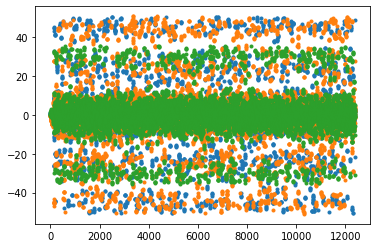

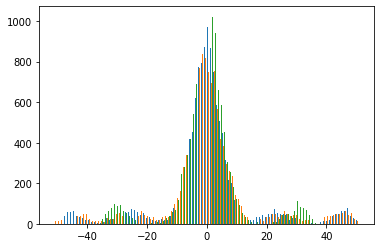

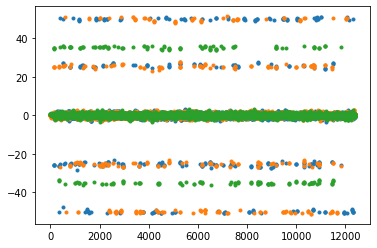

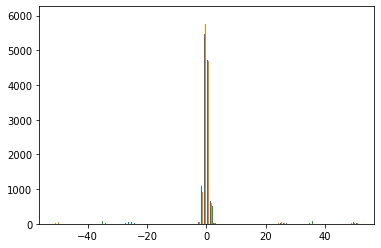

In [43]:
i = 5

single_diff = trajs[i][1] - trajs[i - 1][0]

plt.plot(single_diff, '.')

plt.figure()
plt.hist(single_diff, bins=100)

single_diff = trajs[i][1] - trajs[i - 1][1]

plt.figure()
plt.plot(single_diff, '.')

plt.figure()
plt.hist(single_diff, bins=100)

### box cell

is it constant over time? namely, is the simulation done either at constant volume or pressure??

In [32]:
print(paths_traj[0][:-15])
file_list = os.listdir(paths_traj[0][:-15])

print(np.unique([s[-4:] for s in file_list]))

my_path = '/net/sbp/srnas2/tfrahlki/Simulations/GACC_TREMD'
print(my_path)
file_list = os.listdir(my_path)

print(np.unique([s[-4:] for s in file_list]))

/net/sbp/srnas2/tfrahlki/Simulations/GACC_TREMD/Production/GACC/
['.cpt' '.dat' '.edr' '.gro' '.log' '.ndx' '.npy' '.out' '.pdb' '.top'
 '.tpr' '.trr' '.xtc' '0.sh' '1.sh' '2.sh' '3.sh' '4.sh' '5.sh' '6.sh'
 '7.sh' '8.sh' '9.sh' 'D.10' 'D.11' 'D.12' 'D.13' 'D.14' 'D.15' 'D.16'
 'D.17' 'D.18' 'D.19' 'D.20' 'D.21' 'D.22' 'D.23' 'SD.0' 'SD.1' 'SD.2'
 'SD.3' 'SD.4' 'SD.5' 'SD.6' 'SD.7' 'SD.8' 'SD.9' 'a.sh' 'b.1#' 'c.1#'
 'c.2#' 'c.3#' 'c.4#' 'c.5#' 'c.6#' 'c.7#']
/net/sbp/srnas2/tfrahlki/Simulations/GACC_TREMD
['.cpt' '.dat' '.edr' '.gro' '.itp' '.log' '.mdp' '.ndx' '.pdb' '.top'
 '.tpr' '.trr' '.xtc' '.xvg' '0.sh' '1.sh' '2.sh' '3.sh' '4.sh' '5.sh'
 '6.sh' '7.sh' '8.sh' '9.sh' 'D.10' 'D.11' 'D.12' 'D.13' 'D.14' 'D.15'
 'D.16' 'D.17' 'D.18' 'D.19' 'D.20' 'D.21' 'D.22' 'D.23' 'SD.0' 'SD.1'
 'SD.2' 'SD.3' 'SD.4' 'SD.5' 'SD.6' 'SD.7' 'SD.8' 'SD.9' 'W.ff' 'a.sh'
 'ints' 'n.sh' 'pynb' 'ties' 'tion']


In [34]:
!pwd

/u/i/igilardo/5_Jeffreys/my_scripts/demuxing


In [35]:
# look at this .ipynb for the MD simulation: the pressure is constant with Parrinello-Rahman coupling (barostat)
!cp /net/sbp/srnas2/tfrahlki/Simulations/GACC_TREMD/TREMD_script_GROMACS.ipynb .

In [36]:
xtc_read = mda.coordinates.XTC.XTCReader(paths_traj[1] % 1)

xtc_read[start_frame][:].shape#.flatten()

/u/i/igilardo/.local/lib/python3.6/site-packages/MDAnalysis/coordinates/XDR.py:232: UserWarning: Couldn't save offsets because: [Errno 13] Permission denied: '/net/sbp/srnas2/tfrahlki/Simulations/GACC_TREMD/Production/GACC/.traj_comp1.part0002.xtc_offsets.npz'
  warnings.warn("Couldn't save offsets because: {}".format(e))


(12377, 3)

In [37]:
for i in range(5):
    print(xtc_read[i])

< Timestep 0 with unit cell dimensions [51.0528   51.0528   51.052814 60.000008 60.000008 90.      ] >
< Timestep 1 with unit cell dimensions [51.0528   51.0528   51.052814 60.000008 60.000008 90.      ] >
< Timestep 2 with unit cell dimensions [51.0528   51.0528   51.052814 60.000008 60.000008 90.      ] >
< Timestep 3 with unit cell dimensions [51.0528   51.0528   51.052814 60.000008 60.000008 90.      ] >
< Timestep 4 with unit cell dimensions [51.0528   51.0528   51.052814 60.000008 60.000008 90.      ] >


In [39]:
vars(xtc_read[0])

{'frame': 0,
 '_n_atoms': 12377,
 'data': {'time': 8000.0, 'step': 4000000, 'dt': 1.0},
 '_has_positions': True,
 '_has_velocities': False,
 '_has_forces': False,
 '_has_dimensions': False,
 '_pos': array([[12.3      , 19.91     , 22.83     ],
        [12.610001 , 19.02     , 22.66     ],
        [11.52     , 18.17     , 22.92     ],
        ...,
        [ 7.11     , 49.39     ,  7.8800006],
        [40.160004 , 45.410004 , 23.600002 ],
        [46.140003 ,  7.31     , 29.770002 ]], dtype=float32),
 '_unitcell': array([51.0528  , 51.0528  , 51.052814, 60.000008, 60.000008, 90.      ],
       dtype=float32),
 'aux': {}}

In [12]:
for i in range(5):
    print(xtc_read[i])


< Timestep 0 with unit cell dimensions [51.0528   51.0528   51.052814 60.000008 60.000008 90.      ] >
< Timestep 1 with unit cell dimensions [51.0528   51.0528   51.052814 60.000008 60.000008 90.      ] >
< Timestep 2 with unit cell dimensions [51.0528   51.0528   51.052814 60.000008 60.000008 90.      ] >
< Timestep 3 with unit cell dimensions [51.0528   51.0528   51.052814 60.000008 60.000008 90.      ] >
< Timestep 4 with unit cell dimensions [51.0528   51.0528   51.052814 60.000008 60.000008 90.      ] >


In [12]:
vars(xtc_read)



array([51.0491  , 51.0491  , 51.049175, 59.999985, 59.999985, 90.      ],
      dtype=float32)

In [10]:
from demuxing_fun import reciprocal_lattice, periodical_distance

In [1]:
def periodical_distance(x1, x2, matrix, inv_matrix):
    # for single particles:
    # s_12 = np.dot(inv_matrix, x2 - x1)
    # s_12 -= np.round(s_12)
    # dist = np.linalg.norm(np.dot(matrix, s_12))

    # else:
    diff = x2 - x1
    diff = np.reshape(diff, (-1, 3))

    s_12 = np.dot(inv_matrix, diff.T)
    s_12 -= np.round(s_12)

    # dist = np.mean(np.linalg.norm(np.dot(matrix, s_12), axis=0))

    return dist

In [11]:
xtc_read = mda.coordinates.XTC.XTCReader(paths_traj[0] % 0)
ts = xtc_read.ts.dimensions

out = reciprocal_lattice(ts)

In [21]:
h = reciprocal_lattice(ts, 'primitive vectors')
h_inv = np.linalg.inv(h)
my_fun = lambda x1, x2 : periodical_distance(x1, x2, h, h_inv)

diff = distance.cdist(trajs[8], trajs[9], my_fun)

In [16]:
print(trajs[8][0, :6])
print(trajs[9][0, :6])
print(trajs[9][1, :6])

[33.800003 29.29     12.360001 34.5      29.550001 12.97    ]
[33.590004 28.58     11.190001 34.050003 29.020002 11.910001]
[33.960003 30.790003 14.29     34.68     30.860003 14.920001]


In [22]:
diff

array([[ 8.66417999,  1.09675474, 12.1195643 , 15.87683305, 20.86489111,
        22.3112346 , 22.98603471, 18.61725426, 23.60242364, 23.53819379,
        23.78657611, 23.31433879, 23.61815048, 23.88749206, 23.97487122,
        23.95773834, 23.91237464, 23.71834378, 23.79948424, 23.58762593,
        24.01813334, 24.04240715, 24.17730415, 24.14137264],
       [ 1.06805673,  8.71697099,  9.02165458, 13.4037457 , 19.80021846,
        21.69296026, 22.55241972, 17.12647745, 23.36889474, 23.53950919,
        23.61019726, 23.13950917, 23.51664803, 23.66494565, 23.86508851,
        24.03681197, 23.83809293, 24.07312593, 24.02018872, 23.53615171,
        23.84133709, 24.26546121, 24.18128845, 24.10721727],
       [ 8.97896194, 12.09374351,  1.14742959, 10.03736526, 18.15784875,
        20.85691668, 21.99939849, 14.41046857, 23.15561138, 23.33980544,
        23.52052371, 22.88253683, 23.55555996, 23.99604653, 23.95694885,
        23.98926354, 23.84682763, 24.10176729, 23.97040235, 23.62302451,
  

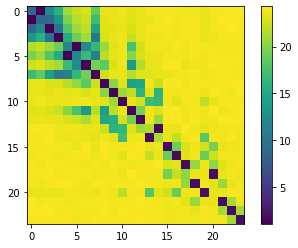

In [23]:
plt.imshow(diff)
plt.colorbar()

triclinic crystal system

- https://github.com/MDAnalysis/mdanalysis/blob/develop/package/MDAnalysis/coordinates/XTC.py

- https://aflow.org/p/triclinic_lattice.html

- https://watermark.silverchair.com/ appendix B: crystal systems and the reciprocal lattice

`xtc_read` returns the edge lengths and the angles $(a, b, c, \alpha, \beta, \gamma)$.

In our case, this means: the simulation box is a parallelepiped with edges

$\vec a_1 = \hat x$,   $\vec a_2 = \hat y$,   $\vec a_3 = \frac{1}{2}\hat x + \frac{1}{2}\hat y + \frac{\sqrt 2}{2}\hat z$

in units of $51.0491$.


distances in triclinic boxes with PBCs:

- https://github.com/mdtraj/mdtraj/issues/908

In this case, two angles are approx. 60° and the third is 90°. This means, 

In [15]:
unit_length = 51.0491

36.097164783470184

In [35]:
n_frame = 5
n_temp = 1

trajs[n_frame][n_temp].shape

(12388, 3)

In [46]:
diff = np.abs(trajs[n_frame][1] - trajs[n_frame - 1][0])

print(diff)

arg = 2*np.pi*(diff[:, 0] + diff[:, 1] + np.sqrt(2)*diff[:, 2])
cos_dist = 1 - np.cos(arg)

cos_dist = 1 - np.cos(np.sum(arg))



cos_dist

[[1.1000023e+00 4.0000916e-02 9.5000076e-01]
 [1.2400017e+00 4.9000168e-01 8.0999947e-01]
 [1.1300049e+00 2.8000259e-01 9.8999977e-01]
 ...
 [2.4910000e+01 2.4570004e+01 3.5740002e+01]
 [1.9699993e+00 2.4000549e-01 5.6000137e-01]
 [4.9450005e+01 7.9998016e-02 2.6000023e-01]]


1.533962607383728

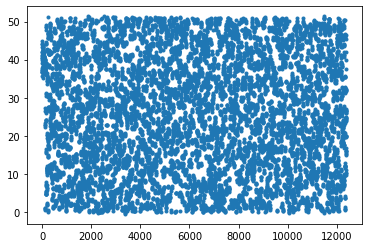

In [14]:
plt.plot(xtc_read[3][:][:, 1], '.')

In [ ]:
cos_diff = trajs[i][1] - trajs[i - 1][0]


In [75]:
my_vec = np.random.rand(20)

print(my_vec)

my_vec[2::3]

[0.84813077 0.60749879 0.60258524 0.4851856  0.77893403 0.34344637
 0.68319988 0.52786189 0.86560355 0.30189143 0.07392064 0.8329246
 0.09610098 0.03374846 0.34581896 0.92978378 0.58980338 0.52357675
 0.33434325 0.91044506]


array([0.60258524, 0.34344637, 0.86560355, 0.8329246 , 0.34581896,
       0.52357675])

In [136]:
def my_fun(x1, x2):
    unit_length = 51.0491
    diff = np.abs(x2 - x1)
    arg = 2*np.pi*(diff[::3] + diff[1::3] + np.sqrt(2)*diff[2::3])/unit_length
    cos_dists = 1 - np.cos(arg)
    cos_dist = np.mean(cos_dists)
    # cos_dist = 1 - np.cos(np.sum(arg))
    return cos_dist, cos_dists

In [142]:
def my_fun3(x1, x2):
    unit_length = 51.0491
    diff = np.abs(x2 - x1)
    diff[::3] -= np.rint(diff[::3]/unit_length)*unit_length
    diff[1::3] -= np.rint(diff[1::3]/unit_length)*unit_length
    diff[2::3] -= np.rint(diff[2::3]*np.sqrt(2)/unit_length)*unit_length/np.sqrt(2)
    return diff

In [124]:
def my_fun2(x1, x2):
    return (x1 - x2)**2

In [126]:
my_fun2(trajs[i - 1][0], trajs[i][0])

array([2.8900674e-02, 4.0001830e-04, 1.0889995e-01, ..., 1.2959975e-01,
       1.5999970e-01, 4.8999974e-01], dtype=float32)

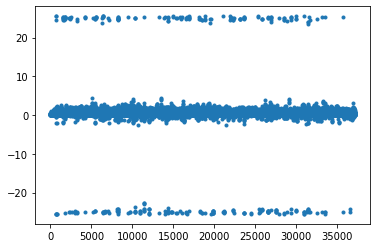

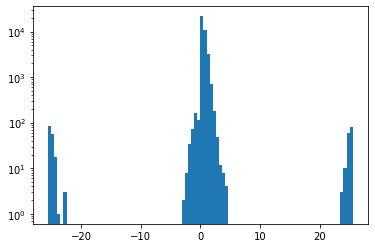

In [144]:
plt.plot(my_fun3(trajs[i - 1][0], trajs[i][0]), '.')

plt.figure()
plt.hist(my_fun3(trajs[i - 1][0], trajs[i][0]), bins=100)
plt.yscale('log')

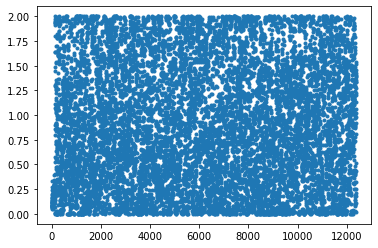

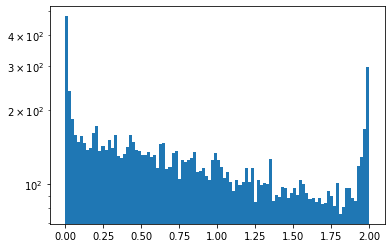

In [139]:
plt.plot(my_fun(trajs[i - 1][0], trajs[i][1])[1], '.')

plt.figure()
plt.hist(my_fun(trajs[i - 1][0], trajs[i][1])[1], bins=100)
plt.yscale('log')

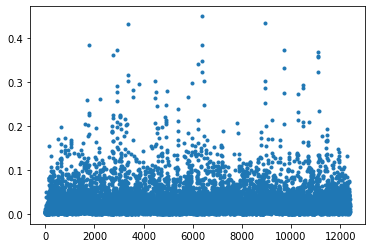

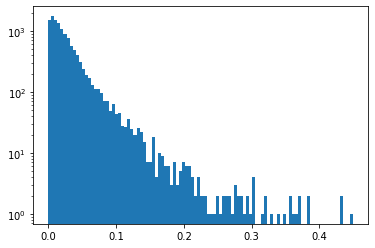

In [138]:
plt.plot(my_fun(trajs[i - 1][0], trajs[i][0])[1], '.')

plt.figure()
plt.hist(my_fun(trajs[i - 1][0], trajs[i][0])[1], bins=100)
plt.yscale('log')

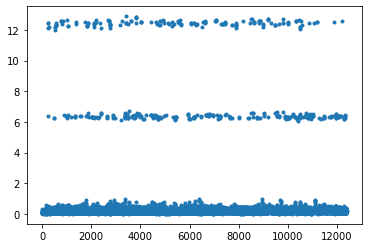

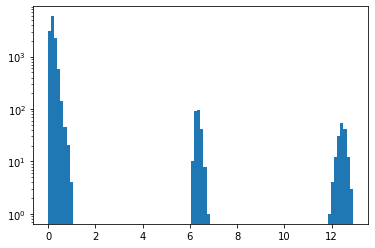

In [133]:
plt.plot(my_fun(trajs[i - 1][0], trajs[i][0])[1], '.')

plt.figure()
plt.hist(my_fun(trajs[i - 1][0], trajs[i][0])[1], bins=100)
plt.yscale('log')

(array([3.025e+03, 5.896e+03, 2.259e+03, 5.900e+02, 1.400e+02, 4.600e+01,
        2.100e+01, 4.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+01,
        9.300e+01, 9.500e+01, 4.100e+01, 8.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+0

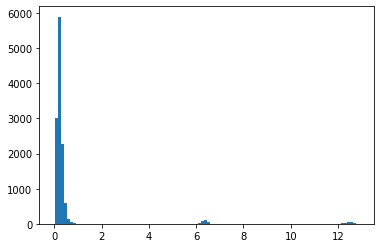

In [115]:
plt.hist(my_fun(trajs[i - 1][0], trajs[i][0])[1], bins=100)
# plt.hist(my_fun(trajs[i - 1][0], trajs[i][1])[1], bins=100)

In [84]:
trajs[i].shape

(24, 37164)

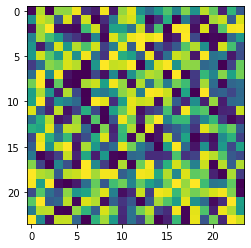

In [112]:
dist = distance.cdist(trajs[i - 1], trajs[i], metric=my_fun)

plt.imshow(dist)

In [69]:
def my_flatten(traj_frame):
    return np.array([traj_frame[j].flatten() for j in range(len(traj_frame))])

In [70]:
x = my_flatten(trajs[i - 1])
x_new = my_flatten(trajs[i])

distance.cdist(x, x_new)

array([[1025.15181184, 2713.68740052, 3301.36662288, 3060.54348993,
        3550.73327793, 3420.10854579, 3625.44014265, 3611.93891578,
        3677.34224637, 3625.21607998, 3650.92723408, 3676.66489877,
        3631.96855676, 3619.84603197, 3684.27459523, 3666.22527088,
        3660.48630294, 3632.22154499, 3632.37752519, 3671.89413356,
        3676.06097538, 3694.34987117, 3633.92111292, 3679.42342084],
       [2700.81447608, 1035.43197946, 3159.78272926, 2725.85233549,
        3479.88537712, 3347.97962964, 3579.9741573 , 3625.42109252,
        3663.37291943, 3622.33950027, 3644.59226711, 3662.00842651,
        3630.98890877, 3610.72822021, 3663.17253349, 3639.79375834,
        3663.03760821, 3628.20235636, 3641.83476626, 3663.90097193,
        3667.21573849, 3671.15453804, 3664.31908094, 3680.03847856],
       [3068.16385185, 2734.96000023, 2879.83043279, 1069.9918083 ,
        3412.97069521, 3217.55340411, 3516.2176376 , 3569.92439532,
        3661.25645698, 3636.03652533, 3637.373

In [68]:
x

AttributeError: 'tuple' object has no attribute 'shape'

In [65]:
distance.cdist(x, x_new)#, metric=my_fun)

ValueError: XA must be a 2-dimensional array.

In [ ]:
trajs[i - 1]

In [48]:
i = 1

diff, ind = main_demuxing(trajs[i - 1], trajs[i])

plt.imshow(diff)

ValueError: XA must be a 2-dimensional array.

[[229.  33.  11.  29.  10.  10.   4.   7.  13.  10.   7.  17.   6.  12.
    8.  13.  10.   6.  12.   7.   9.  10.   9.   6.]
 [ 32. 252.  19.  22.  10.  14.   7.   5.   7.  12.   7.   6.   5.   6.
   11.   6.   7.   8.  12.   7.  12.  12.   6.   4.]
 [ 18.  21.  24. 210.  11.  16.  11.  10.   7.  11.  12.  12.   7.   8.
    5.   6.   7.  13.  10.   9.  13.   6.   7.   6.]
 [ 11.  17. 199.  24.  22.  28.  14.   5.   7.   5.  11.  10.   4.  15.
    9.   9.   9.   8.  13.   6.   5.   6.   4.  14.]
 [ 11.  15.  18.  20.  24. 202.  14.  16.  14.  10.   7.   5.   8.  11.
    6.   6.   4.   7.   9.  12.   5.  11.  10.   5.]
 [  8.   8.  23.  16. 195.  20.  21.  13.  11.   9.  12.   5.   3.   5.
   15.   3.   9.   6.   6.   9.   6.   8.  14.   3.]
 [  6.  11.   9.  16.  21.  22. 228.  22.  13.   7.   9.   4.   6.   9.
   10.   6.   6.  10.   5.   7.  17.   7.  12.   9.]
 [  8.  11.  12.  11.  12.   9.  16. 173.  20.  11.  10.  10.   8.   9.
    5.   9.  12.   9.   6.   8.   9.   9.   5.  10.]


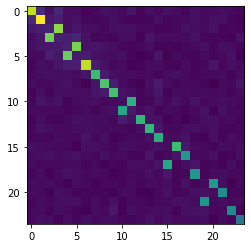

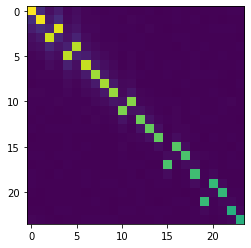

In [15]:
i = 1

for threshold in [1e-3, 1]:
    diff, ind = main_demuxing(trajs[i - 1], trajs[i], threshold=threshold)

    print(diff)

    plt.figure()
    plt.imshow(diff)

#### from https://github.com/mdtraj/mdtraj/issues/908

$H = (\vec a, \vec b, \vec c)$

$\vec s_{12} = H^{-1}\vec{AC}$

$\vec s_{12} \, -= \, \mathrm{np.round}(\vec s_{12})$

$||H \vec s_{12}||$

notice $H^{-1} = (\vec g_1, \vec g_2, \vec g_3)^T / 2\pi$

In [7]:
n_atoms = 2

# build unit cell and positions
# ts = mda.coordinates.base.Timestep(n_atoms)
ts_pos0 = np.array([0.9, 0.5, 0.1])
ts_pos1 = np.array([0.1, 0.5, 0.9])
dimensions = [1, np.sqrt(2), 1, 60, 60, 90]

# calculate H matrix and its inverse
def abc_to_hmatrix(a, b, c, alpha, beta, gamma, degrees=True):
        if degrees: alpha, beta, gamma = map(np.radians, (alpha, beta, gamma))
        result = np.zeros((3, 3))

        a = np.array((a, 0, 0))
        b = b * np.array((np.cos(gamma), np.sin(gamma), 0))
        bracket = (np.cos(alpha) - np.cos(beta) * np.cos(gamma)) / np.sin(gamma)
        c = c * np.array((np.cos(beta), bracket, np.sqrt(np.sin(beta) ** 2 - bracket ** 2)))

        result[:, 0] = a
        result[:, 1] = b
        result[:, 2] = c

        return result

hmat = abc_to_hmatrix(*dimensions)
hinv = np.linalg.inv(hmat)

# calculate distance according to Tuckerman
# s_1 = np.dot(hinv, ts_pos0)
# s_2 = np.dot(hinv, ts_pos1)
# s_12 = s_1 - s_2
s_12 = np.dot(hinv, ts_pos0 - ts_pos1)
s_12 -= np.round(s_12)
print('Expected distance by Tuckerman  ', np.linalg.norm(np.dot(hmat, s_12)))

# calculate distance by enumeration
dist = 100000
for i in range(-2, 2):
    for j in range(-2, 2):
        for k in range(-2, 2):
            dist = min(np.linalg.norm(ts_pos0+i*hmat[:, 0]+j*hmat[:,1]+k*hmat[:,2]-ts_pos1), dist)
print('Expected distance by enumeration', dist)

# calculate distance with transposed Hmat
s_1 = np.dot(hinv.T, ts_pos0)
s_2 = np.dot(hinv.T, ts_pos1)
s_12 = s_1-s_2
s_12 -= np.round(s_12)
print('Wrong distance by Tuckerman     ', np.linalg.norm(np.dot(hmat.T, s_12)))

# writer = mda.coordinates.DCD.DCDWriter('mdtraj-pbc.dcd', n_atoms)
# writer.write_next_timestep(ts)
# writer.close()

[ 1.36568542  0.4        -1.13137085]
Expected distance by Tuckerman   0.5904482620022894
Expected distance by enumeration 0.5904482620022893
Wrong distance by Tuckerman      0.23031443252638928


#### compare the time required for each iteration with different def.s of distance

In [9]:
from demuxing_fun import demuxing_single_move, reciprocal_lattice, periodical_distance

In [10]:
trajs[0].shape

(24, 37131)

In [11]:
my_fun = 'sqeuclidean'

%timeit demuxing_single_move(trajs[0], trajs[1], my_fun)

28.2 ms ± 2.71 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [12]:
my_fun = lambda x1, x2 : 1/len(np.where(np.abs(x1 - x2) < 1.)[0])

%timeit demuxing_single_move(trajs[0], trajs[1], my_fun)


62.1 ms ± 4.36 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [13]:
cell = np.array([33.800003, 29.29, 12.360001, 34.5, 29.550001, 12.97])
h = reciprocal_lattice(cell, 'primitive vectors')
h_inv = np.linalg.inv(h)
my_fun = lambda x1, x2 : periodical_distance(x1, x2, h, h_inv)

%timeit demuxing_single_move(trajs[0], trajs[1], my_fun)


355 ms ± 26.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [28]:
def periodical_distance(x1, x2, matrix, inv_matrix):
    # for single particles:
    # s_12 = np.dot(inv_matrix, x2 - x1)
    # s_12 -= np.round(s_12)
    # dist = np.linalg.norm(np.dot(matrix, s_12))

    # else:
    diff = x2 - x1
    diff = np.reshape(diff, (-1, 3))

    s_12 = np.dot(inv_matrix, diff.T)
    s_12 -= np.round(s_12)

    dist = np.mean(np.linalg.norm(np.dot(matrix, s_12), axis=0))

    ### approximations:
    # dist = np.mean(np.linalg.norm(s_12, axis=0))
    # dist = np.linalg.norm(s_12)  # slower
    # dist = np.mean(np.abs(s_12))  # faster

    return dist

In [24]:
cell = np.array([33.800003, 29.29, 12.360001, 34.5, 29.550001, 12.97])
h = reciprocal_lattice(cell, 'primitive vectors')
h_inv = np.linalg.inv(h)
my_fun = lambda x1, x2 : periodical_distance(x1, x2, h, h_inv)

%timeit demuxing_single_move(trajs[0], trajs[1], my_fun)


245 ms ± 17.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [20]:
cell = np.array([33.800003, 29.29, 12.360001, 34.5, 29.550001, 12.97])
h = reciprocal_lattice(cell, 'primitive vectors')
h_inv = np.linalg.inv(h)
my_fun = lambda x1, x2 : periodical_distance(x1, x2, h, h_inv)

%timeit demuxing_single_move(trajs[0], trajs[1], my_fun)

454 ms ± 94.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


#### triclinic system: cosine distance

reciprocal lattice

In [61]:
xtc_read.ts

< Timestep 0 with unit cell dimensions [51.0491   51.0491   51.049175 59.999985 59.999985 90.      ] >

In [58]:
ts = np.array([1, 1, 1, 60, 60, 90])


In [59]:
out = reciprocal_lattice(ts, False)

In [60]:
[out[1][i]/(2*np.pi) for i in range(3)]

[array([ 1.00000000e+00, -6.12323400e-17, -7.07106781e-01]),
 array([ 0.        ,  1.        , -0.70710678]),
 array([0.        , 0.        , 1.41421356])]

### analysis of the results

In [9]:
paths_traj

['/net/sbp/srnas2/tfrahlki/Simulations/CCCC_TREMD/Production/CCCC/traj_comp%s.xtc',
 '/net/sbp/srnas2/tfrahlki/Simulations/CCCC_TREMD/Production/CCCC/traj_comp%s.part0002.xtc',
 '/net/sbp/srnas2/tfrahlki/Simulations/CCCC_TREMD/Production/CCCC/traj_comp%s.part0003.xtc',
 '/net/sbp/srnas2/tfrahlki/Simulations/CCCC_TREMD/Production/CCCC/traj_comp%s.part0004.xtc',
 '/net/sbp/srnas2/tfrahlki/Simulations/CCCC_TREMD/Production/CCCC/traj_comp%s.part0005.xtc',
 '/net/sbp/srnas2/tfrahlki/Simulations/CCCC_TREMD/Production/CCCC/traj_comp%s.part0006.xtc',
 '/net/sbp/srnas2/tfrahlki/Simulations/CCCC_TREMD/Production/CCCC/traj_comp%s.part0007.xtc',
 '/net/sbp/srnas2/tfrahlki/Simulations/CCCC_TREMD/Production/CCCC/traj_comp%s.part0008.xtc',
 '/net/sbp/srnas2/tfrahlki/Simulations/CCCC_TREMD/Production/CCCC/traj_comp%s.part0009.xtc',
 '/net/sbp/srnas2/tfrahlki/Simulations/CCCC_TREMD/Production/CCCC/traj_comp%s.part0010.xtc',
 '/net/sbp/srnas2/tfrahlki/Simulations/CCCC_TREMD/Production/CCCC/traj_comp%s.p

In [35]:
# n_subtraj = -2
n_rep = 0

ns_frame = []

for path_traj in paths_traj:
    xtc_read = mda.coordinates.XTC.XTCReader(path_traj % n_rep)
    ns_frame.append(xtc_read.n_frames)

/u/i/igilardo/.local/lib/python3.6/site-packages/MDAnalysis/coordinates/XDR.py:232: UserWarning: Couldn't save offsets because: [Errno 13] Permission denied: '/net/sbp/srnas2/tfrahlki/Simulations/CCCC_TREMD/Production/CCCC/.traj_comp0.xtc_offsets.npz'
  warnings.warn("Couldn't save offsets because: {}".format(e))
/u/i/igilardo/.local/lib/python3.6/site-packages/MDAnalysis/coordinates/XDR.py:232: UserWarning: Couldn't save offsets because: [Errno 13] Permission denied: '/net/sbp/srnas2/tfrahlki/Simulations/CCCC_TREMD/Production/CCCC/.traj_comp0.part0002.xtc_offsets.npz'
  warnings.warn("Couldn't save offsets because: {}".format(e))
/u/i/igilardo/.local/lib/python3.6/site-packages/MDAnalysis/coordinates/XDR.py:232: UserWarning: Couldn't save offsets because: [Errno 13] Permission denied: '/net/sbp/srnas2/tfrahlki/Simulations/CCCC_TREMD/Production/CCCC/.traj_comp0.part0003.xtc_offsets.npz'
  warnings.warn("Couldn't save offsets because: {}".format(e))
/u/i/igilardo/.local/lib/python3.6/si